In [1]:
import sys
import os

baseDir =  os.path.dirname(os.path.abspath(''))
modelDir = os.path.join(baseDir, "Model")
dataDir = os.path.join(baseDir, "Analysis\DFs")

sys.path.append(baseDir)
sys.path.append(modelDir)
sys.path.append(dataDir)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Model.MenloLoader import *
from Model.MenloLoader import MenloLoader


plt.rcParams["figure.figsize"] = (7,6)

In [2]:
ref1 = pd.read_pickle(os.path.join(dataDir, '90-90-360_proper.pkl'))
samp1 = pd.read_pickle(os.path.join(dataDir, '90-90-360_proper1CA.pkl'))
ref2 = pd.read_pickle(os.path.join(dataDir, '90-90-360_proper2.pkl'))
samp2 = pd.read_pickle(os.path.join(dataDir, '90-90-360_proper2GlucoseD.pkl'))

ml = MenloLoader([])

dfs = [ref1,samp1,ref2,samp2]

ang = np.linspace(90,-90,360)

for df in dfs:
    df["phi"] = ang

In [3]:
ref3 = pd.read_pickle(os.path.join(dataDir, 'Ref3_90-90_360.pkl'))
samp3 = pd.read_pickle(os.path.join(dataDir, 'CA4_90-90_360.pkl'))
ref4 = pd.read_pickle(os.path.join(dataDir, 'Ref4_90-90_360.pkl'))
samp4 = pd.read_pickle(os.path.join(dataDir, 'GD4_90-90_360.pkl'))

ml = MenloLoader([])

dfs = [ref3,samp3,ref4,samp4]

ang = np.linspace(90,-90,360)

for df in dfs:
    df["phi"] = ang

In [4]:
def get_FD(self,time, TDS_signal): 

    c_FFT = []
    # Pad zeros on the time signal to reach this length
    t_ser_len = 16384
    phase = []
    e_time = time
    e_amp = TDS_signal
    T = e_time[1]-e_time[0]                      
    e_time = e_time - time[0]
    N0 = len(e_time)
    # e_time = e_time[:(self.find_nearest(e_time, self.win)[0])]                   
    # e_amp = e_amp[:(self.find_nearest(e_time, self.win)[0])]
    N = len(e_time)              
    w = sgnl.tukey(N, alpha = 0.1) 

    e_amp = w*(e_amp)                                     

    pad = t_ser_len - N  
    e_time = np.append(e_time, np.zeros(pad))          
    e_amp = np.append(e_amp, np.zeros(pad))
    N0 = len(e_time)

    freq = np.fft.fftfreq(N0, T)
    zero_THz_idx = self.find_nearest(freq, 0)[0]
    freq= freq[zero_THz_idx:int(len(freq)/2)]
    e_FFT = np.fft.fft(e_amp)/(N0/2)   
    e_FFT = e_FFT[zero_THz_idx:int(len(e_FFT)/2)]     
    FFT = np.abs(e_FFT)

    for j in range(len(e_FFT)):
        phase.append(np.arctan2(e_FFT[j].imag,e_FFT[j].real))
    phase = np.array(phase)
    start = self.find_nearest(freq,0)[0]
    stop = self.find_nearest(freq,4)[0]
    slc_freq = freq[start:stop]
    phase = phase[start:stop]
    slc_FFT = FFT[start:stop]                        
    p_freq = slc_freq
    phase = phase
    c_FFT.append({'freq':freq,
                    'FFT': FFT, 'c_FFT': e_FFT,
                    'p_freq' : p_freq ,
                    'phase' : phase,'slc_FFT' : slc_FFT})
    c_FFT = pd.DataFrame(c_FFT)
    return c_FFT


def get_mat_params2(df,d):
    c = 2.998e8
    pi = np.pi  
    a,n = [[] for i in range(2)]
    for j in range(len(df)):
        #excpects df with col sgn = 1 or -1
        sgn = -1
        
        f = df.loc[j]['freq']
        start = df.loc[j]['p_freq'][0]
        end = df.loc[j]['p_freq'][-1]
        n_start = ml.find_nearest(f,start)[0]
        n_end = ml.find_nearest(f,end)[0]
        T = df.loc[j]['c_tr'][n_start:n_end+1]
        n.append(1+(sgn*(df.loc[j]['pd']/(df.loc[j]['p_freq']*1e12))*c/(2*pi*d)))
        a.append(-(2/(d*1e2)*np.log((1+n[-1])**2/(4*n[-1])*T)).real)
    df['Absorption'] = a
    df['n_eff'] = n
    return df

In [5]:
from scipy import signal
from scipy.signal import filtfilt, iirnotch, freqz
from sklearn.linear_model import LinearRegression

def get_samples2(df_m, df_r):
    rdfs,p_d, tr, c_tr, filt_TR = [[] for i in range(5)]
        
    for j in range(len(df_m)):
        p_d.append(df_m.loc[j]['phase'] - df_r.loc[j]['phase'])
        tr.append(df_r.loc[j]['FFT']/df_m.loc[j]['FFT'])
        c_tr.append(df_r.loc[j]['c_FFT']/df_m.loc[j]['FFT'])
    df_m['pd'] = p_d
    df_m['tr'] = tr
    df_m['c_tr'] = c_tr             
    return df_m

def convDF(df):
    res = pd.DataFrame()
    for i in range(len(df)):
        time = df.loc[i]['time']
        amp = df.loc[i]['amp']

        res = pd.concat([res, ml.get_FD(time, amp)])

    res = res.reset_index(drop = True)
    return res


def unwrp_phase(df,key):
      """Performs phase unwrapping on the values of a specified key in given dataframe.
      
          *Arguments*
  
          df : Dataframe object
          key: key to the data e.g. 'phase' or phase difference 'pd'. This series 
                    must have the same length as the array with key 'p_freq'.

          *Returns*

          df: Dataframe object with unwrapped phase
      """
      freq_lst = []
      phase_lst = []
      for i in range(len(df)) :
          phase = df.loc[i]['%s'%key]
          p_freq = df.loc[i]['p_freq']
          for k in range(1):
              for m in range(1,len(phase)):
                  diff = phase[m] - phase[m-1]
                  if diff > np.pi:
                      phase[m:] = phase[m:] - 2*np.pi
                  elif diff < -np.pi:
                      phase[m:] = phase[m:] + 2*np.pi                        
          x0 = ml.find_nearest(p_freq,0.1)
          x1 = ml.find_nearest(p_freq,0.3)
          ex_freq = p_freq[x0[0]:x1[0]].reshape((-1,1))
          ex_phase = phase[x0[0]:x1[0]]
          model = LinearRegression().fit(ex_freq,ex_phase)
          #r_sq = model.score(ex_freq,ex_phase)
          offset = model.intercept_
          phase = phase[x0[0]:] - offset
          p_freq = p_freq[x0[0]:] 
          freq_lst.append(p_freq)
          phase_lst.append(phase)
      df['%s'%key] = phase_lst
      df['p_freq'] = freq_lst  
      return df  
    

In [17]:
ref3.to_pickle(os.path.join(dataDir, 'Ref3_90-90_360.pkl'))
samp3.to_pickle(os.path.join(dataDir, 'CA4_90-90_360.pkl'))
ref4.to_pickle(os.path.join(dataDir, 'Ref4_90-90_360.pkl'))


In [25]:
samp4.to_pickle(os.path.join(dataDir, 'GD4_90-90_360.pkl'))

In [6]:
Ref1 = convDF(ref1)
Samp1 = convDF(samp1)
Samp2 = convDF(samp2)
Ref2 = convDF(ref2)

Ref3 = convDF(ref3)
Samp3 = convDF(samp3)
Samp4 = convDF(samp4)
Ref4 = convDF(ref4)

Samp1 = get_samples2(Samp1, Ref1)
Samp2 = get_samples2(Samp2, Ref2)
Samp3 = get_samples2(Samp3, Ref3)


#Samp3.head()

In [7]:
Samp4 = get_samples2(Samp4, Ref4)


In [8]:
Samp4


,freq,FFT,c_FFT,p_freq,phase,slc_FFT,pd,tr,c_tr
0,"[0.0, 0.0018310546776782732, 0.003662109355356...","[0.0008555525532074233, 0.0010066615728796986,...","[(-0.0008555525532074233+0j), (0.0007997224956...","[0.0, 0.0018310546776782732, 0.003662109355356...","[3.141592653589793, -0.6527272588000774, 1.389...","[0.0008555525532074233, 0.0010066615728796986,...","[0.0, 0.33222542211016426, -0.4731763321972870...","[0.4962490493661725, 0.7346175214576764, 1.250...","[(-0.4962490493661724+0j), (0.4061718961182461..."
1,"[0.0, 0.0018310546727978024, 0.003662109345595...","[0.001350880387888986, 0.0011587832434497504, ...","[(-0.001350880387888986+0j), (0.00100844012164...","[0.0, 0.0018310546727978024, 0.003662109345595...","[3.141592653589793, -0.5150709591549619, 1.645...","[0.001350880387888986, 0.0011587832434497504, ...","[0.0, 0.11974220128124402, -0.1356069229249998...","[0.8397168879923949, 0.751837238037154, 0.9849...","[(-0.8397168879923949+0j), (0.6053661955234245..."
2,"[0.0, 0.0018310546731818702, 0.003662109346363...","[0.0018246911416553557, 0.0012395459660819474,...","[(-0.0018246911416553557+0j), (0.0011728147071...","[0.0, 0.0018310546731818702, 0.003662109346363...","[3.141592653589793, -0.3296220239324218, 1.882...","[0.0018246911416553557, 0.0012395459660819474,...","[0.0, 0.6238432410553195, 0.12602825270937412,...","[0.21082476068521938, 0.581498951347923, 0.520...","[(-0.2108247606852194+0j), (0.3366070077196986..."
3,"[0.0, 0.0018310546729789076, 0.003662109345957...","[0.001167151662792311, 0.0009544447690361405, ...","[(-0.001167151662792311+0j), (0.00082694518431...","[0.0, 0.0018310546729789076, 0.003662109345957...","[3.141592653589793, -0.5228192249581073, 1.703...","[0.001167151662792311, 0.0009544447690361405, ...","[0.0, 0.10248907591049627, 0.06974637435954456...","[0.8888034703188953, 0.7756009358203071, 1.112...","[(-0.8888034703188953+0j), (0.6288438169655041..."
4,"[0.0, 0.0018310546725885948, 0.003662109345177...","[0.0008754860288671939, 0.0010323641060003992,...","[(-0.0008754860288671939+0j), (0.0008006959980...","[0.0, 0.0018310546725885948, 0.003662109345177...","[3.141592653589793, -0.683139850347751, 1.7945...","[0.0008754860288671939, 0.0010323641060003992,...","[0.0, 0.14407742269651003, -0.1052926485326013...","[0.6948851568018726, 0.7627519989962219, 0.852...","[(-0.6948851568018725+0j), (0.5163271218750789..."
...,...,...,...,...,...,...,...,...,...
355,"[0.0, 0.0018310546731693802, 0.003662109346338...","[0.0013288671530629795, 0.0010768786557258634,...","[(-0.0013288671530629795+0j), (0.0009643615199...","[0.0, 0.0018310546731693802, 0.003662109346338...","[3.141592653589793, -0.46120813910263414, 1.55...","[0.0013288671530629795, 0.0010768786557258634,...","[0.0, 0.06546602717921768, -0.1312386690219238...","[0.8966199795886152, 0.875225146420558, 0.8841...","[(-0.8966199795886151+0j), (0.756617798887311-..."
356,"[0.0, 0.0018310546729227025, 0.003662109345845...","[0.0010881533081260868, 0.0010087502259582333,...","[(-0.0010881533081260868+0j), (0.0008624195251...","[0.0, 0.0018310546729227025, 0.003662109345845...","[3.141592653589793, -0.5453638281357589, 1.484...","[0.0010881533081260868, 0.0010087502259582333,...","[0.0, 0.052441522971249044, -0.343211106067905...","[0.9898232747125725, 0.9889636685815607, 1.145...","[(-0.9898232747125724+0j), (0.817450486723007-..."
357,"[0.0, 0.0018310546730944401, 0.003662109346188...","[0.0013382370104232568, 0.0011329862377640971,...","[(-0.0013382370104232568+0j), (0.0010125063762...","[0.0, 0.0018310546730944401, 0.003662109346188...","[3.141592653589793, -0.4653564408597271, 1.758...","[0.0013382370104232568, 0.0011329862377640971,...","[0.0, -0.16186619554036413, -0.070030708903005...","[1.3466339674096182, 0.9720930722535223, 1.462...","[(-1.3466339674096182+0j), (0.9276676745613074..."
358,"[0.0, 0.0018310546727790674, 0.003662109345558...","[0.0017096070756218253, 0.0012027049562325536,...","[(-0.0017096070756218253+0j), (0.0011

In [ ]:
Samp1 = unwrp_phase(Samp1, 'pd')
Samp2= unwrp_phase(Samp2, 'pd')

In [9]:

Samp3= unwrp_phase(Samp3, 'pd')
Samp4= unwrp_phase(Samp4, 'pd')


def correct_phase(df):
    for i in range(len(df)):
        phase_offset_idx = ml.find_nearest(df.loc[i]['p_freq'], 0.12)[0]
        df.at[i,'pd'] = df.loc[i]['pd'] - df.loc[i]['pd'][phase_offset_idx] 
        return df
    
Samp1 = correct_phase(Samp1)
Samp2 = correct_phase(Samp2)
Samp3 = correct_phase(Samp3)
Samp4 = correct_phase(Samp4)


In [15]:
f_Samp1 = get_mat_params2(Samp1, d = 50-6)
f_Samp2 = get_mat_params2(Samp2, d = 50e-6)

In [22]:
f_Samp3 = get_mat_params2(Samp3, d = 60e-6)
f_Samp4 = get_mat_params2(Samp4, d = 60e-6)

<IPython.core.display.Javascript object>


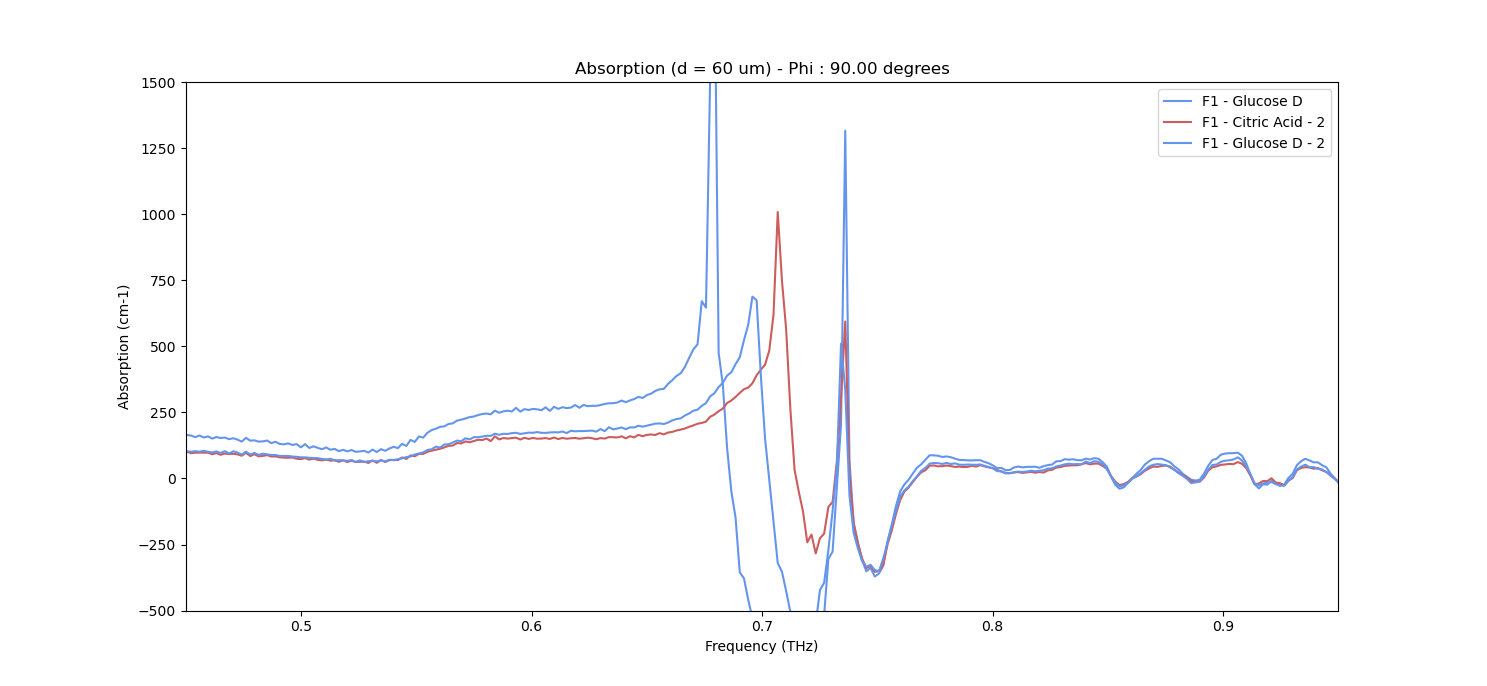

In [26]:
%matplotlib notebook
phi = 90
phi_idx, phi_val = ml.find_nearest(ref1.phi, phi)
df = f_Samp1
df2 = f_Samp2
df3 = f_Samp3
df4 = f_Samp4

plt.rcParams["figure.figsize"] = (15,3)


#plt.plot(df.loc[phi_idx]['p_freq'], -df.loc[phi_idx]['Absorption'], color = 'indianred', label = 'F1 - Citric Acid')
plt.plot(df2.loc[phi_idx]['p_freq'], -df2.loc[phi_idx]['Absorption'], color = 'cornflowerblue', label = 'F1 - Glucose D')
plt.plot(df3.loc[phi_idx]['p_freq'], -df3.loc[phi_idx]['Absorption'], color = 'indianred', label = 'F1 - Citric Acid - 2')
plt.plot(df4.loc[phi_idx]['p_freq'], -df4.loc[phi_idx]['Absorption'], color = 'cornflowerblue', label = 'F1 - Glucose D - 2')
plt.xlim(0.45,0.95)
plt.ylim(-500,1500)
plt.legend(loc = "best")
plt.xlabel("Frequency (THz)")
plt.ylabel("Absorption (cm-1)")
plt.title(f"Absorption (d = 60 um) - Phi : {phi_val:.2f} degrees")
plt.show()





<IPython.core.display.Javascript object>


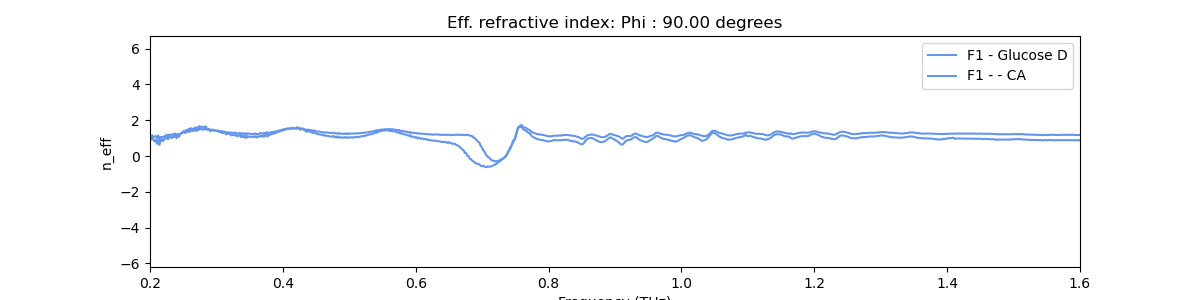

In [28]:
%matplotlib notebook
phi = 90
phi_idx, phi_val = ml.find_nearest(ref1.phi, phi)
df = f_Samp1
df2 = f_Samp2
plt.rcParams["figure.figsize"] = (12,3)

#plt.plot(df.loc[phi_idx]['p_freq'], df.loc[phi_idx]['n_eff'], color = 'indianred', label = 'F1 - Citric Acid')
plt.plot(df2.loc[phi_idx]['p_freq'], df2.loc[phi_idx]['n_eff'], color = 'cornflowerblue', label = 'F1 - Glucose D')
plt.plot(df3.loc[phi_idx]['p_freq'], df3.loc[phi_idx]['n_eff'], color = 'cornflowerblue', label = 'F1 - - CA')
plt.xlim(0.2,1.6)
#plt.ylim(0.9,1.1)

plt.legend(loc = "best")
plt.xlabel("Frequency (THz)")
plt.ylabel("n_eff")
plt.title(f"Eff. refractive index: Phi : {phi_val:.2f} degrees")
plt.show()




<IPython.core.display.Javascript object>


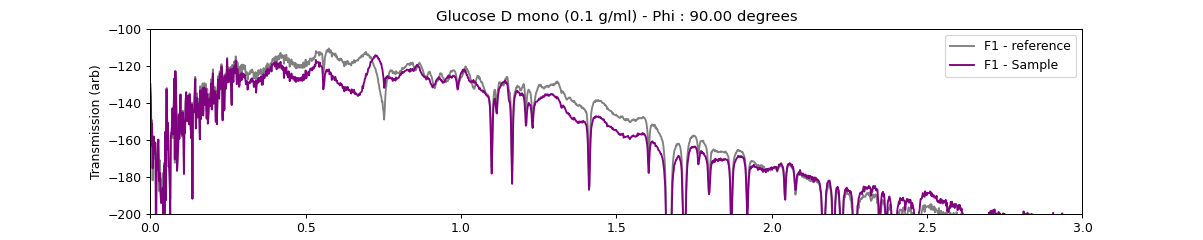

In [116]:
%matplotlib notebook

phi = 90
phi_idx, phi_val = ml.find_nearest(ref2.phi, phi)

plt.rcParams["figure.figsize"] = (15,3)

plt.plot(Ref2.loc[phi_idx]['freq'], 20*np.log(abs(Ref2.loc[phi_idx]['FFT'])), color = 'gray', label = 'F1 - reference')
plt.plot(Ref2.loc[phi_idx]['freq'], 20*np.log(abs(f_Samp2.loc[phi_idx]['FFT'])), color = 'purple',label = 'F1 - Sample')
plt.xlim(0,3)
plt.ylim(-200,-100)
plt.legend(loc = 'best')
plt.xlabel("Frequency (THz)")
plt.ylabel("Transmission (arb)")

plt.title(f"Glucose D mono (0.1 g/ml) - Phi : {phi_val:.2f} degrees")
plt.show()

<IPython.core.display.Javascript object>


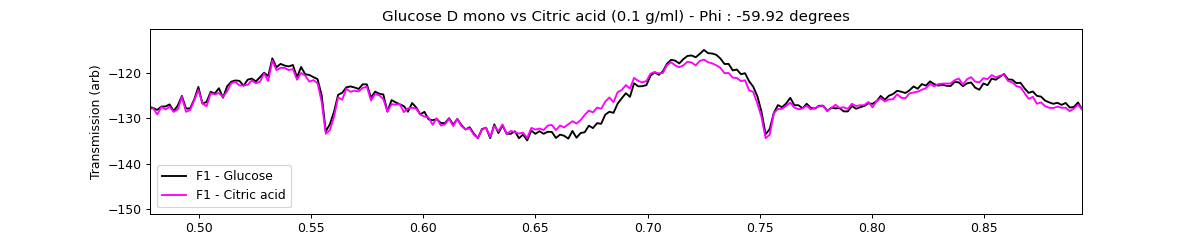

In [104]:
%matplotlib notebook

# phi = 60

phi = -60
phi_idx, phi_val = ml.find_nearest(ref2.phi, phi)
plt.rcParams["figure.figsize"] = (15,3)

plt.plot(Ref2.loc[phi_idx]['freq'], 20*np.log(abs(f_Samp2.loc[phi_idx]['FFT'])), color = 'black', label = 'F1 - Glucose')
plt.plot(Ref1.loc[phi_idx]['freq'], 20*np.log(abs(f_Samp1.loc[phi_idx]['FFT'])), color = 'magenta',label = 'F1 - Citric acid')
plt.xlim(0,3)
plt.ylim(-200,-100)
plt.legend(loc = 'best')
plt.xlabel("Frequency (THz)")
plt.ylabel("Transmission (arb)")

plt.title(f"Glucose D mono vs Citric acid (0.1 g/ml) - Phi : {phi_val:.2f} degrees")
plt.show()

<IPython.core.display.Javascript object>


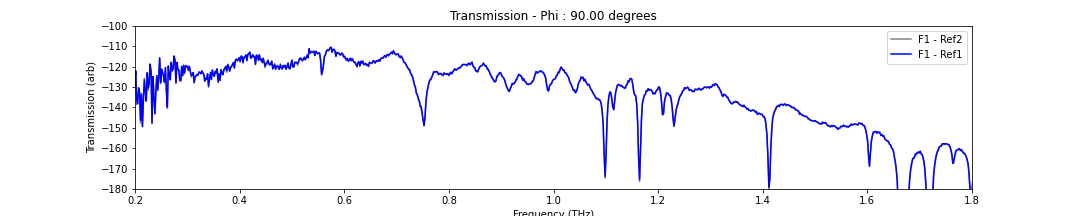

In [82]:
%matplotlib notebook
phi = 90
phi_idx, phi_val = ml.find_nearest(ref2.phi, phi)
plt.rcParams["figure.figsize"] = (15,3)


#plt.plot(ref2.loc[phi_idx]['freq'], 20*np.log(abs(samp2.loc[phi_idx]['FFT'])), color = 'black', label = 'F1 - Glucose')
#plt.plot(ref1.loc[phi_idx]['freq'], 20*np.log(abs(samp1.loc[phi_idx]['FFT'])), color = 'magenta',label = 'F1 - Citric acid')
plt.plot(ref2.loc[phi_idx]['freq'], 20*np.log(abs(ref2.loc[phi_idx]['FFT'])), color = 'grey', label = 'F1 - Ref2')
plt.plot(ref1.loc[phi_idx]['freq'], 20*np.log(abs(ref1.loc[phi_idx]['FFT'])), color = 'blue',label = 'F1 - Ref1')
plt.xlim(0.2,1.8)
plt.ylim(-180,-100)
plt.legend(loc = 'best')
plt.xlabel("Frequency (THz)")
plt.ylabel("Transmission (arb)")

plt.title(f"Transmission - Phi : {phi_val:.2f} degrees")
plt.show()

In [13]:

# phi = 60
%matplotlib notebook
phi = 90
phi_idx, phi_val = ml.find_nearest(ref2.phi, phi)

plt.rcParams["figure.figsize"] = (15,3)


plt.plot(Ref2.loc[phi_idx]['freq'], 20*np.log(abs(f_Samp2.loc[phi_idx]['FFT'])), color = 'black', label = 'F1 - Glucose')
plt.plot(Ref1.loc[phi_idx]['freq'], 20*np.log(abs(f_Samp1.loc[phi_idx]['FFT'])), color = 'magenta',label = 'F1 - Citric acid')
plt.plot(Ref2.loc[phi_idx]['freq'], 20*np.log(abs(Ref2.loc[phi_idx]['FFT'])), color = 'grey', label = 'F1 - Ref2')
plt.plot(Ref1.loc[phi_idx]['freq'], 20*np.log(abs(Ref1.loc[phi_idx]['FFT'])), color = 'blue',label = 'F1 - Ref1')

plt.title(f"Transmission - Phi : {phi_val:.2f} degrees")
phi = 0
phi_idx, phi_val = ml.find_nearest(ref2.phi, phi)

plt.plot(Ref2.loc[phi_idx]['freq'], 20*np.log(abs(Ref2.loc[phi_idx]['FFT'])), color = 'green', label = 'F1 - Ref2 (0.25 deg)')
plt.plot(Ref1.loc[phi_idx]['freq'], 20*np.log(abs(Ref1.loc[phi_idx]['FFT'])), color = 'lime',label = 'F1 - Ref1 (0.25 deg)')

plt.xlim(0,2.5)
plt.ylim(-175,-100)
plt.legend(loc = 'best')
plt.xlabel("Frequency (THz)")
plt.ylabel("Transmission (arb)")

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


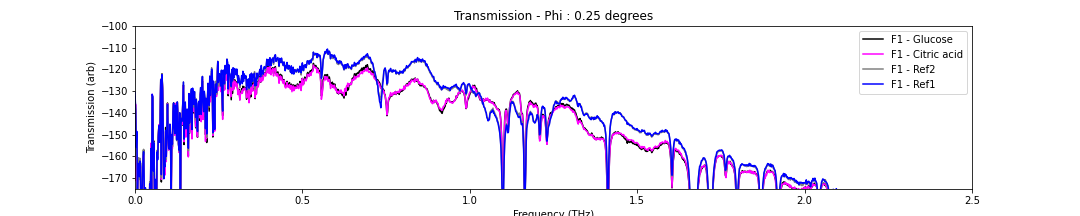

In [61]:

# phi = 60
%matplotlib notebook
phi = 0
phi_idx, phi_val = ml.find_nearest(ref2.phi, phi)

plt.rcParams["figure.figsize"] = (15,3)


plt.plot(ref2.loc[phi_idx]['freq'], 20*np.log(abs(samp2.loc[phi_idx]['FFT'])), color = 'black', label = 'F1 - Glucose')
plt.plot(ref1.loc[phi_idx]['freq'], 20*np.log(abs(samp1.loc[phi_idx]['FFT'])), color = 'magenta',label = 'F1 - Citric acid')
plt.plot(ref2.loc[phi_idx]['freq'], 20*np.log(abs(ref2.loc[phi_idx]['FFT'])), color = 'grey', label = 'F1 - Ref2')
plt.plot(ref1.loc[phi_idx]['freq'], 20*np.log(abs(ref1.loc[phi_idx]['FFT'])), color = 'blue',label = 'F1 - Ref1')

plt.title(f"Transmission - Phi : {phi_val:.2f} degrees")
# phi = 0
# phi_idx, phi_val = ml.find_nearest(ref2.phi, phi)

# plt.plot(ref2.loc[phi_idx]['freq'], 20*np.log(abs(ref2.loc[phi_idx]['FFT'])), color = 'green', label = 'F1 - Ref2 (0.25 deg)')
# plt.plot(ref1.loc[phi_idx]['freq'], 20*np.log(abs(ref1.loc[phi_idx]['FFT'])), color = 'lime',label = 'F1 - Ref1 (0.25 deg)')

plt.xlim(0,2.5)
plt.ylim(-175,-100)
plt.legend(loc = 'best')
plt.xlabel("Frequency (THz)")
plt.ylabel("Transmission (arb)")

plt.show()

<IPython.core.display.Javascript object>


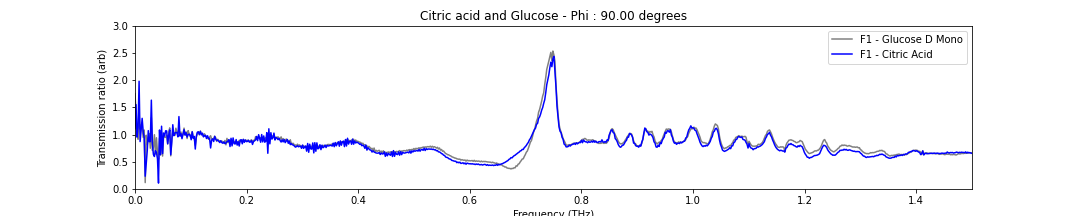

In [58]:

# phi = 60
%matplotlib notebook
phi = 90
phi_idx, phi_val = ml.find_nearest(ref2.phi, phi)
plt.rcParams["figure.figsize"] = (15,3)


#plt.plot(ref2.loc[phi_idx]['freq'], 20*np.log(abs(ref2.loc[phi_idx]['FFT']/samp2.loc[phi_idx]['FFT'])), color = 'grey', label = 'F1 - Glucose D Mono')
#plt.plot(ref1.loc[phi_idx]['freq'], 20*np.log(abs(ref1.loc[phi_idx]['FFT']/samp1.loc[phi_idx]['FFT'])), color = 'blue',label = 'F1 - Citric Acid')
plt.plot(ref2.loc[phi_idx]['freq'], samp2.loc[phi_idx]['FFT']/ref2.loc[phi_idx]['FFT'], color = 'grey', label = 'F1 - Glucose D Mono')
plt.plot(ref1.loc[phi_idx]['freq'], samp1.loc[phi_idx]['FFT']/ref1.loc[phi_idx]['FFT'], color = 'blue',label = 'F1 - Citric Acid')

plt.xlim(0,1.5)
plt.ylim(0,3)
plt.legend(loc = 'best')
plt.xlabel("Frequency (THz)")
plt.ylabel("Transmission ratio (arb)")

plt.title(f"Citric acid and Glucose - Phi : {phi_val:.2f} degrees")
plt.show()

<IPython.core.display.Javascript object>


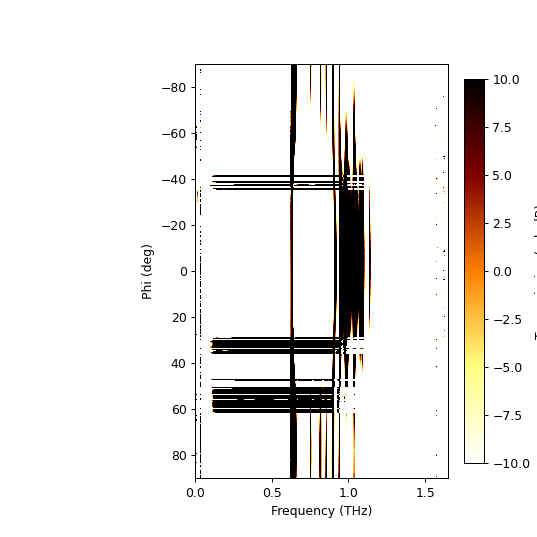

In [169]:
%matplotlib notebook
imrows = []
phis = []
df = f_Samp1
df['phi'] = np.linspace(90,-90,360)
for i in range(len(df)):
    imrows.append((df.loc[i]['Absorption'][:900]))  # only take spectra till 3.479 THz
    phis.append(df.loc[i]['phi'])
imrows = np.array(imrows)


fig, ax = plt.subplots(figsize=(6,6))

fLim = df.loc[0]['freq'][900]  # 1.6 THz
phiScan = ax.imshow(imrows, cmap= 'afmhot_r', vmin =-10 , vmax = 10,extent =[df.loc[0]['freq'][0], fLim, phis[0],phis[-1]])
ax.set_aspect(0.015)
ax.set_xlabel("Frequency (THz)")
ax.set_ylabel("Phi (deg)")

cbar = fig.colorbar(phiScan, ax = ax, location = 'right', fraction=0.046, pad=0.04)

cbar.set_label("Transmission (arb dB)")
plt.show()